# Introduction
In this notebook I am going to explain the steps that I followed to suggest descriptive and predictive analysis of future merchants transactions/growth data.


## Technical specifications

* To run notebook on your machine please create a virtual environment with python 3.6.x, or pyton 2.7.x and install:
  * tensorflow (if CPU `pip install tensorflow`, if GPU `pip install tensorflow-gpu`).
  * keras
  * matplotlib
  * seaborn
  * pandas
  * scikit-learn
  * numpy

* To run this notebook in a virtual environment:

 * create and activate a Python virtual environment (let's call it `test-virtualenv`), then run the following two commands.
 
 * `(test-virtualenv) $ pip install ipykernel`
 
 * `(test-virtualenv) $ ipython kernel install --user --name=test-virtualenv`
 
 * start jupyter notebook and select the virtual environment from the Kernel menu (Kernel -> change kernel)

In [559]:
# To display and store the plots within the notebook.
%matplotlib inline
import seaborn as sns; sns.set()

# Reading and pre-processing the data

## Checking the raw data
Using the bash command `head` on the provided raw file, we can quickly check the data and see that we have three columns, one of them is a date time column that needs to be properly parsed.

In [560]:
%%bash

head -10 case_final.csv

user,time,amount_in_cents
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-19T23:39:56.925Z",1203
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-19T23:41:47.026Z",1203
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-23T15:19:54.836Z",2405
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-23T15:21:08.273Z",2405
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-24T15:19:39.386Z",1203
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-24T19:07:41.768Z",3007
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-24T19:14:07.347Z",3007
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-24T19:37:20.946Z",1203
"00038f0484334ac047449166cfbbf6452b31c85c","2016-02-24T21:46:34.232Z",1203


## Loading and pre-processing of the Data <a id='loading_original_anchor'></a>

- We will load the data into a Pandas Dataframe.
- The dates need to be parsed in order to convert it to a datetime type, for that we will define a custom function ```parse_datetime```.
- Additional columns will be created from the parsed date, in order to facilitate further analysis and grouping on the data.

In [523]:
from pandas import read_csv
import pandas as pd
import datetime


# A helper function that parses the date.
# Remark: by starting with a very simple parse, I noticed that not all dates will get parsed. 
#         The dates have two fomrats: %Y-%m-%dT%H:%M:%SZ or %Y-%m-%dT%H:%M:%S.ZZZZ
#         that's why two corresponding parsing templates are used.
def parse_datetime(dt_str):
        date_parts = dt_str.split(".")
        if len(date_parts) == 1: # The format is %Y-%m-%dT%H:%M:%SZ
            return datetime.datetime.strptime(dt_str, "%Y-%m-%dT%H:%M:%SZ")
        else: # The format is %Y-%m-%dT%H:%M:%S.ZZZZ
            dt, _, us = dt_str.partition(".")
            dt = datetime.datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
            us = int(us.rstrip("Z"), 10)
            return dt + datetime.timedelta(microseconds=us)
    
# Reading the raw csv:
# By using the parse_dates argument, we specify which column in the origninal data represents a datetime value.
# To create a date column we use parse_datetime function defined above and we assign it to the date_parser argument
# By doing so, we will get a datetime column that replaces the original string column
df = read_csv('case_final.csv',  parse_dates = ['time'], date_parser=parse_datetime)

# Make sure that there is no null values in the dataframe
print("Null Values exist: %r" % df.isnull().values.any())

# We use the time column to extract additional columns that represent the day, month, year and hour
# These columns will help us later for both our descriptive and predictive analysis
df['day'] = df.time.dt.day
df['month'] = df.time.dt.month
df['year'] = df.time.dt.year

# Two additional columns that will be used later when we design a prediction algorithm
# The first one is the number of days in month.
# The second is a year-month datetime format 
#   (basically it is the same as the time column but without the day, hour, minute, seconds information)
df['days_in_month'] = df.time.dt.daysinmonth
df['year_month'] = df.time.dt.to_period('M')

Null Values exist: False


## Aggregating the data per user


In [527]:
# Using the groupby function in Pandas, I extracted the first and last datetimes where the user was active.
# I have also generated the sum, minimum and maximum of amounts for each user,
#         in addition to the total number of transactions done by the user.

df_user_agg = df.groupby('user').agg({'time':["min", "max"], 'amount_in_cents':["sum", "min", "max", "count"]}).reset_index()

# The following two lines are for naming the new columns
df_user_agg.columns = df_user_agg.columns.droplevel(0)
df_user_agg.columns = ['user', 'min_time', 'max_time', 'total_amount', 'min_amount', 'max_amount', 'num_trans']

### What are the features that describe a merchant?

After grouping and aggregating the data per user, we need to think about the features that describe the activities of the merchants.

My reasoning is focused on the following facts:
- The longer the period where the merchant appears in the data the more important the merchant is.
- The more transactions the merchant does the better.
- The higher amounts the merchant spends the better.

We can define an attractive merchant as: **"A merchant who is active for a long period, and doing frequent transactions with high amounts."**

If a merchant shows a behaviour similar to those attractive merchants then we can expect that he is or he will become in the near future an attractive merchant as well.

To translate the three points mentioned above, I defined three new columns:
- **active_period**: the number of days between the min and max dates for each user.
- **avg_daily_amount**: the average amount that the merchant has spent on a daily basis during his active_period. Which is the total_amount claculated in the previous cell devided by the active_period.
- **avg_daily_trans**: the average number of daily transactions that the user did during his active period. Which is the total number of transaction (num_trans claculated in the previous cell) devided by the active_period.

Note that the *active_period* is simply the difference (in term of days) between the earlist transaction date and the latest transaction date for a particular user. It is not necessary to find transactions in each day during this period, this period can be sparse.

In [531]:
# Adding three columns calculated from the columns built in the previous cell.
df_user_agg['active_period'] = (df_user_agg['max_time']-df_user_agg['min_time']).dt.days.add(1)
df_user_agg['avg_daily_amount'] = df_user_agg['total_amount']/df_user_agg['active_period']
df_user_agg['avg_daily_trans'] = df_user_agg['num_trans']/df_user_agg['active_period']

### Highly skewed data!
By calling the **describe** function on a DataFrame, we can get a summary of the values of each column.
As we see in the next cell:
- we have in total 8402 merchants in our dataset.
- 25% of the merchants are only active for very short period (25% of the merchants have active_period euqal or less than 4). But despite this start, the rest of the values looks like distributed in an equivalent way (this will be clearer in the cell after the table).
- the average daily amount varies greatly, between zero and ~5.7 millions cents. With an average of only 20 thousands, which means a high skew to the right.
- the same can be noticed with the average daily transactions. Most merchants do no more than 1 transaction per day (75% of all merchant do in aveage one or less than one transaction per day). While the maximum value can go up to 476.
- These observations are made clearer after two cells, where we can see the frequency distribution graphs.

In [532]:
df_user_agg[['active_period', 'avg_daily_amount', 'avg_daily_trans']].describe()

,active_period,avg_daily_amount,avg_daily_trans
count,8402.000000,8.402000e+03,8402.000000
mean,156.157463,2.104727e+04,1.357604
std,140.138524,1.256426e+05,8.832509
min,1.000000,0.000000e+00,0.005731
25%,4.000000,4.810000e+02,0.070423
50%,133.000000,2.119866e+03,0.299010
75%,304.000000,9.002371e+03,1.000000
max,366.000000,5.670619e+06,476.500000


### Visualising the features of all users

Here I provide an equivalent visualisation of the table above.
I order the users by the value of each feature and plot all values.
- The figures show that very few merchants have large averge number of transactions per day and a large average daily amount.
- In the blue figure we find about 2000 merchants with very short active period, then the the curve goes up smoothly, which means that we can find merchants who fall in any active period. **This is an oportunity for the sales/data teams to try to identify which interval we can focus on in order to retain the merchants inside it.**

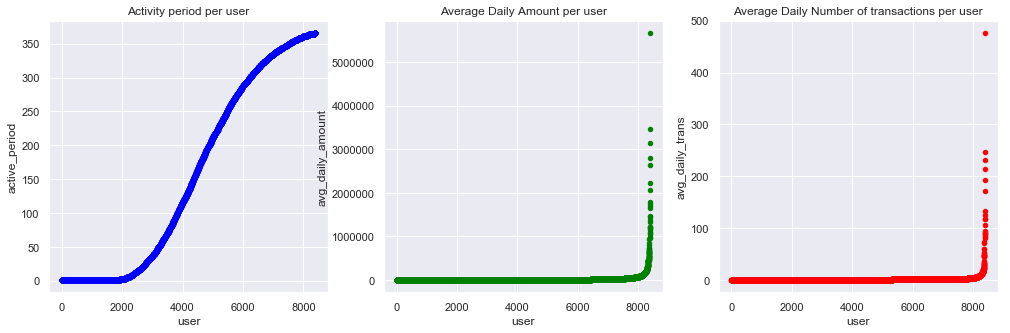

In [574]:
fig, axes = pyplot.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(17)

ax = df_user_agg.sort_values(by=['active_period']).reset_index().reset_index()\
            .plot(x='level_0', y='active_period', kind="scatter", ax=axes[0], color="blue")
ax.set_ylabel("active_period")
ax.set_xlabel("user")
ax.set_title("Activity period per user")

ax = df_user_agg.sort_values(by=['avg_daily_amount']).reset_index().reset_index()\
            .plot(x='level_0', y='avg_daily_amount', kind="scatter", ax=axes[1], color="green")
ax.set_ylabel("avg_daily_amount")
ax.set_xlabel("user")
ax.set_title("Average Daily Amount per user")

ax = df_user_agg.sort_values(by=['avg_daily_trans']).reset_index().reset_index()\
            .plot(x='level_0', y='avg_daily_trans', kind="scatter", ax=axes[2], color="red")
ax.set_ylabel("avg_daily_trans")
ax.set_xlabel("user")
ax.set_title("Average Daily Number of transactions per user")

fig.show()

### Frequency histograms the three features 'active_period', 'avg_daily_amount' and 'avg_daily_trans'

A simple call for the plot.hist function in Pandas can show us the frequency of the values.
I have set the number of bin to 30. This parameter is used for illustartion, any other reasonable value can be used.
- The figures confirm that each of 'avg_daily_amount' and 'avg_daily_trans' features is extremely skewed to the right. The vast majority of the data falls in the first bin to the left (the bin of the smallest values).
- we can identify two dominant bins in the 'active_period' hitogram. The extreme left (the smallest values) and extreme right bins (the largest values), which means that most of the merchants are active for very short period, and many users are active for long period.
- This highlights some points that need attention from the business/sales specialists:
  - **why most of the users are only active for short period?** this is an important question that needs to be answered to reduce the churn rate.
  - Almost all merchants have low-volume (i.e. low number of transaction per day, and low average daily amount). it looks like the company is successful in attracing these customers. **Is this true? maybe the high churn rate is giving the illusion that the low-volume customers are attracted successfully to the business.  In any case, the sales and data analytics teams need to know why high-volumn merchants are as frequent**.

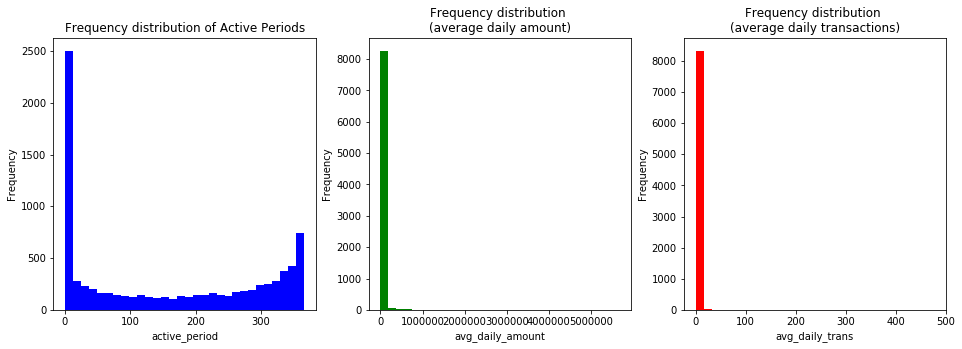

In [553]:
from matplotlib import pyplot

df_user_agg = df_user_agg[['user', 'active_period', 'avg_daily_amount', 'avg_daily_trans']]

fig, axes = pyplot.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(16)

ax = df_user_agg['active_period'].plot.hist(bins=30, ax=axes[0], color="blue")
ax.set_xlabel("active_period")
ax.set_title("Frequency distribution of Active Periods")

ax =df_user_agg['avg_daily_amount'].plot.hist(bins=30, ax=axes[1], color="green")
ax.set_xlabel("avg_daily_amount")
ax.set_title("Frequency distribution \n(average daily amount)")

ax = df_user_agg['avg_daily_trans'].plot.hist(bins=30, ax=axes[2], color="red")
ax.set_xlabel("avg_daily_trans")
ax.set_title("Frequency distribution \n(average daily transactions)")

fig.show()

### Semantic Quantisation of the data

An effective and less technical visualisation is the heatmap or grid views. They help greatly in providing a segmented visualisation of the data.

The three features can be quantized into semantic intervals. Here I decided to do an ad-hoc quantization based on my observations in the previous sections.
- **Quantization of active_period**: as there is many merchants with very short activity period, I have decided to create a dedicated bin for the merchants who were active for only one day. The bin for the merchants active between 2 days and one week. Then I used the median and the maximum values of the active_period to create 2 remaining bins. The result is four bins, labeled semantically as "one_day", "one_week", "short" and "long".
- **Quantizing the avg_daily_amount**: I created a dedicated bin for the merchants who has zero amount, then I used the minimum, median and maximum avg_daily_amount to create 2 reamining bins. The result is three bins, labeled semantically as "zero", "low" and "high".
- **Quantizing the avg_daily_trans**: I simply used the minimum, median and maximum values to create two bins. The  bins are sematntically labeled as "low_freq", "high_freq".

Remark:
- The median is used because it is a robust statistic compared to the average that can change if we add one outlaier.
- I used Pandas embedded functions: median, max, min and **[cut](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.cut.html)** as shown in the next three cells.

In [580]:
active_period_median = df_user_agg['active_period'].median()
active_period_max = df_user_agg['active_period'].max()
active_period_min = df_user_agg['active_period'].min()

avg_daily_amount_median = df_user_agg['avg_daily_amount'].median()
avg_daily_amount_max = df_user_agg['avg_daily_amount'].max()
avg_daily_amount_min = df_user_agg['avg_daily_amount'].min()

avg_daily_trans_median = df_user_agg['avg_daily_trans'].median()
avg_daily_trans_max = df_user_agg['avg_daily_trans'].max()
avg_daily_trans_min = df_user_agg['avg_daily_trans'].min()

In [581]:
df_user_agg['active_length'] = pd.cut(df_user_agg['active_period'], bins=[0, 1, 7, active_period_median,active_period_max], labels=["one_day", "one_week", "short", "long"])
df_user_agg['avg_amount'] = pd.cut(df_user_agg['avg_daily_amount'], bins=[-0.01, avg_daily_amount_min+0.001,avg_daily_amount_median,avg_daily_amount_max], labels=["zero", "low", "high"])
df_user_agg['freq_trans'] = pd.cut(df_user_agg['avg_daily_trans'], bins=[avg_daily_trans_min-1,avg_daily_trans_median,avg_daily_trans_max], labels=["low_freq", "high_freq"])

In [582]:
df_user_agg.head()

,user,active_period,avg_daily_amount,avg_daily_trans,active_length,avg_amount,freq_trans
0,00038f0484334ac047449166cfbbf6452b31c85c,79,12396.493671,3.924051,short,high,high_freq
1,0012a74e2bb1ab0073b2e18532e87474b6b7cfca,6,1523.333333,0.333333,one_week,low,high_freq
2,001855810c25d8bb03210f8c0114de27da9cd76c,359,4196.292479,0.543175,long,high,high_freq
3,001f3978fa7cad62f2e2ddfa155184a316282b0e,358,7735.709497,0.463687,long,high,high_freq
4,00317873b9dcbcff6759f7ec4225d8531520fdcb,3,2686.000000,0.666667,one_week,high,high_freq


### Heatmap/Grid visualization

Now we have the data ready we will simply use the **[seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html)** library to build the heatmap visualization.
- We simply pass our DataFrame (df_user_agg) to the heatmap function of seaborn. The function will aggregate the data and count the number of samples that falls in each grid.
- **Each grid represents a segment of merchants**.
- **The darker the color the lower the number of merchant in the segment.**
- If no samples fall in a segment (grid), the segment will be black.

**Let's start by visualizing the segmentation based on the average amount and the active period lenght.**

By examining the figure we can notice the following:
- **Many merchants (1229) are active for only one day with high amount. More investigations are needed. Although it is understandable to have relatively high amount because the average in that case is the same as the amount itself (i.e. because we are deviding by one). But some cases could be fraud. This segment is very important and need attention to understand why the merchants are falling here. Contacting these merchants directly or access more information from the CRM or other resources might be necessary to gather more information about their business and behaviour.**
- **The majority of the merchants falls into the low average amount and long active length. While it is good to fall in the long active lengh segment, it would be good to try to move these merchants to the lower-right corner (i.e. high average amount and long active lengh). Targetting this segment could be prioritized in order to retain enhance the revenue.**
- There is relatively few merchants in all the 'one_week' active length segments. This means that the merchants are churning in the first day or they stay for longer period. It could be good to investigate more to know why this is happening and how to prevent the churn on the first day.
- There is significan number of merchants falling in the 'short" active lengh segments (the [low-average-amount, short-active_length] has 1078 merchants and [high-average-amount, short-active_length] has 818 merchants). We can recommend to the sales team to target these customers as **they might be considered as customers at risk**. Targeting merchants in these segments and moving them more to the adjustent segments  on the right can help enhancing the **retaintion rate**.

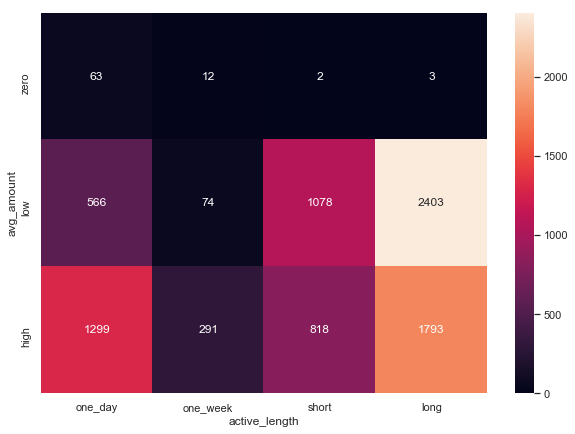

In [594]:
import seaborn as sns; sns.set()
import numpy as np

fig, axes = pyplot.subplots(nrows=1, ncols=1)
fig.set_figheight(7)
fig.set_figwidth(10)

sns.heatmap(df_user_agg.pivot_table(index=["avg_amount"], columns="active_length", aggfunc='size', fill_value=0), vmin=0, fmt="d",annot=True)

fig.show()

**In a similar way, by examining the segments based on the frequency of transactions and the active period length, we note the following**:
- A very large number (1928) of merchants is active for only one day with a high average frequency of transactions. This corresponds to the lower left-most segment. **Similar to the lower left-most segment in the previous visualization, this segment need further investigation to understand why this is happening.** It is understandable that the average will be high as we have only one day, so the average calculation will not be similar to the number of transactions on that day. But some cases where the number of transaction is high (probably over 10) can be indicators for a fraud.
- Similar to the figure above, analytics and sales efforts are needed to move the merchants from to the lower right-most cell. Depends on the priority, we can focus on the upper right-most segment to enhance the revenue, or on the 'short active length' segment to enahnace the retaintion rate.

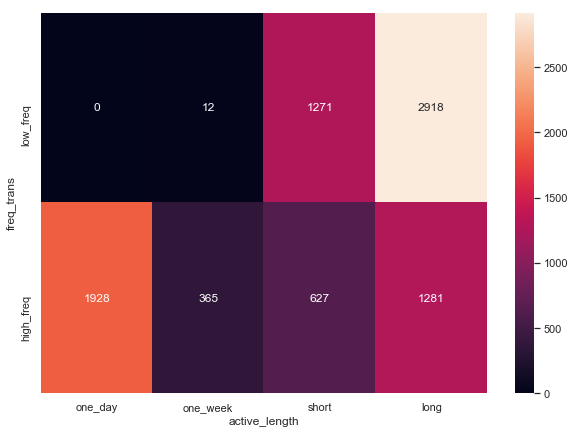

In [596]:
fig, axes = pyplot.subplots(nrows=1, ncols=1)
fig.set_figheight(7)
fig.set_figwidth(10)
sns.heatmap(df_user_agg.pivot_table(index=["freq_trans"], columns="active_length", aggfunc='size', fill_value=0), vmin=0, fmt="d",annot=True)
fig.show()

**Similar analytical reasoning can be done on the segments based on the average daily amount and the average daily transaction frequency. The priority could be to move the merchants as fast as possible from the low averge amount and low frequency segment (3213) towards the lower sgements. This will help in enhancing the revenue.**

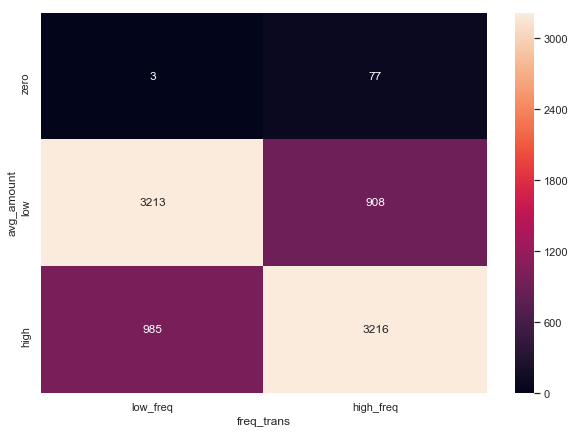

In [601]:
fig, axes = pyplot.subplots(nrows=1, ncols=1)
fig.set_figheight(7)
fig.set_figwidth(10)

sns.heatmap(df_user_agg.pivot_table(index=["avg_amount"], columns="freq_trans", aggfunc='size', fill_value=0), vmin=0, fmt="d",annot=True)
fig.show()

# Part 2: Building Multivariate Recurrent Neural Network Forecast Model (RNN)

## Data Preparation for RNN

The first step is to prepare the dataset for applying RNN regression prediction.

The current dataset is not yet in the form of a supervised learning probem. In order to acheive this goal we need to:
- Normalise the values of each feature column.
- Create sequential form of the feature columns for forcast prediction.

**We will frame the supervised learning problem as predicting the merchant volume (i.e. the total monthly amount) for the current month, given his/her monthly amounts and frequency of transactions during the past 6 months.**

First, the original DataFrame that was built in the [Loading and pre-processing of the Data section](#loading_original_anchor) is used to group the data per user, and month in order to extract the total amount and the total number of transactions per month per user.

In [946]:
df_user_predict_grouped = df.groupby(['user', 'year_month', 'days_in_month']).agg({'amount_in_cents':["sum", "count"]}).reset_index()
df_user_predict_grouped.columns = df_user_predict_grouped.columns.droplevel(0)
df_user_predict_grouped.columns = ['user', 'year_month', 'days_in_month', 'total_month_amount', 'total_month_trans']

In [947]:
df_user_predict_grouped = df.groupby(['user', 'year_month']).agg({'amount_in_cents':["sum", "count"]}).reset_index()
df_user_predict_grouped.columns = df_user_predict_grouped.columns.droplevel(0)
df_user_predict_grouped.columns = ['user', 'year_month', 'total_month_amount', 'total_month_trans']

Next, the features are normalized using sikit-learn MinMaxScaler as shown in the code below.

In [949]:
from sklearn import preprocessing

x = df_user_predict_grouped[['total_month_amount', 'total_month_trans']].values
x = x.astype('float32')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1, 10))
x_scaled = min_max_scaler.fit_transform(x)
df_user_predict_grouped[['total_month_amount', 'total_month_trans']] = pd.DataFrame(x_scaled)

Then the dataset is transformed into a supervised learning problem by applying the [shift](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) functions. The function will help us in creating a series feautre for each user, as follow:

- First we sort the rows in the dataframe by user then by "year_month"
- We apply the function shift 6 times for each feature total_month_amount and total_month_trans, in order to extract the values of these features in the 6 months preceeding the last active month for that user.
- Then, we apply a sequence of operations to fill the gaps between the months (if they exsist) and to build the feature vector in a way that the prediction value will be the total monthly amount of the last active month for each user. Then the feature will be the values of the total_month_amount and the total_month_trans of the 6 months preceeding the last active month.

In [903]:
df_user_predict_grouped = df_user_predict_grouped.sort_values(by=['user', "year_month"])

df_user_predict_grouped = df_user_predict_grouped.set_index(['user', 'year_month'])

df_user_predict_grouped = df_user_predict_grouped.unstack(['year_month']).fillna(0).stack(['year_month']).reset_index()

df_user_predict_grouped["total_month_amount-1"] = df_user_predict_grouped.groupby("user")["total_month_amount"].shift(periods=1)
df_user_predict_grouped["total_month_trans-1"] = df_user_predict_grouped.groupby("user")["total_month_trans"].shift(periods=1)

df_user_predict_grouped["total_month_amount-2"] = df_user_predict_grouped.groupby("user")["total_month_amount"].shift(periods=2)
df_user_predict_grouped["total_month_trans-2"] = df_user_predict_grouped.groupby("user")["total_month_trans"].shift(periods=2)

df_user_predict_grouped["total_month_amount-3"] = df_user_predict_grouped.groupby("user")["total_month_amount"].shift(3 )
df_user_predict_grouped["total_month_trans-3"] = df_user_predict_grouped.groupby("user")["total_month_trans"].shift(3)

df_user_predict_grouped["total_month_amount-4"] = df_user_predict_grouped.groupby("user")["total_month_amount"].shift(4)
df_user_predict_grouped["total_month_trans-4"] = df_user_predict_grouped.groupby("user")["total_month_trans"].shift(4)

df_user_predict_grouped["total_month_amount-5"] = df_user_predict_grouped.groupby("user")["total_month_amount"].shift(5)
df_user_predict_grouped["total_month_trans-5"] = df_user_predict_grouped.groupby("user")["total_month_trans"].shift(5)

df_user_predict_grouped["total_month_amount-6"] = df_user_predict_grouped.groupby("user")["total_month_amount"].shift(6)
df_user_predict_grouped["total_month_trans-6"] = df_user_predict_grouped.groupby("user")["total_month_trans"].shift(6)

In [905]:
df_user_predict_grouped['year_month_max'] = df_user_predict_grouped.loc[uuu['total_month_amount'] > 0].groupby(['user'])['year_month'].transform(max)
df_user_predict_grouped = df_user_predict_grouped.loc[df_user_predict_grouped['year_month']==df_user_predict_grouped['year_month_max']].dropna()

# Selecting the columns that will constitute the time series feature
df_user_predict_grouped = df_user_predict_grouped[['total_month_amount-6', 'total_month_trans-6',
                                                   'total_month_amount-5', 'total_month_trans-5',
                                                   'total_month_amount-4', 'total_month_trans-4',
                                                   'total_month_amount-3', 'total_month_trans-3',
                                                   'total_month_amount-2', 'total_month_trans-2', 
                                                   'total_month_amount-1', 'total_month_trans-1', 
                                                   'total_month_amount']]

In [907]:
# This is how the prediction-ready DataFrame looks like
df_user_predict_grouped.head()

,total_month_amount-6,total_month_trans-6,total_month_amount-5,total_month_trans-5,total_month_amount-4,total_month_trans-4,total_month_amount-3,total_month_trans-3,total_month_amount-2,total_month_trans-2,total_month_amount-1,total_month_trans-1,total_month_amount
6,0.0,0.0,0.0,0.0,0.0,0.0,35000.0,18.0,205671.0,87.0,718808.0,195.0,19844.0
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9140.0
69,117372.0,15.0,129879.0,12.0,129637.0,23.0,244124.0,37.0,436898.0,49.0,411280.0,52.0,25494.0
87,516404.0,26.0,437515.0,25.0,524461.0,34.0,63981.0,7.0,54119.0,13.0,4812.0,4.0,1203.0
140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34154.0,1.0,16716.0


Now we split the data into training and test sets and we reshape it to make it suitable for Recurrent Neural Networks

In [927]:
from sklearn.model_selection import train_test_split

# split into train and test sets
train , test = train_test_split(df_user_predict_grouped.values,test_size=0.2)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] in our case the timesteps is 6, and we have two features
train_X = train_X.reshape((train_X.shape[0], int(train_X.shape[1]/2), 2 ))
test_X = test_X.reshape((test_X.shape[0], int(test_X.shape[1]/2), 2))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5861, 6, 2) (5861,) (1466, 6, 2) (1466,)


## LSTM model training

Classical linear methods in Machine learning can be difficult to adapt to multivariate or multiple input forecasting problems, as they do not take advantage of the sequential nature of time seriesdata , where the past input has an influence on the future ones and on the subsequent results.

Recurrent Neural Netowrk (RNN) is a Deep Learning architecture that memorises the past input and takes it into consideration while processing the current one. This makes the RNNs very good candidate for timeseries forcasting.

LSTM and GRU are the most commonly used types of RNNs. I decided to use LSTM but it can be easily exchenged with GRU in the code below.

In this setup I am trying to solve a regression problem where we are seeking to predict the total_monthly_amount based on the past 6 months' monthly amounts and number of transactions.

Remark: Please scroll to the end to see the graph.

Train on 5861 samples, validate on 1466 samples
Epoch 1/100
 - 15s - loss: 0.8581 - val_loss: 0.5473
Epoch 2/100
 - 0s - loss: 0.4015 - val_loss: 0.1871
Epoch 3/100
 - 0s - loss: 0.1178 - val_loss: 0.0330
Epoch 4/100
 - 0s - loss: 0.0523 - val_loss: 0.0689
Epoch 5/100
 - 0s - loss: 0.0807 - val_loss: 0.0560
Epoch 6/100
 - 0s - loss: 0.0528 - val_loss: 0.0303
Epoch 7/100
 - 0s - loss: 0.0419 - val_loss: 0.0334
Epoch 8/100
 - 0s - loss: 0.0457 - val_loss: 0.0338
Epoch 9/100
 - 0s - loss: 0.0431 - val_loss: 0.0297
Epoch 10/100
 - 0s - loss: 0.0399 - val_loss: 0.0294
Epoch 11/100
 - 0s - loss: 0.0398 - val_loss: 0.0298
Epoch 12/100
 - 0s - loss: 0.0392 - val_loss: 0.0288
Epoch 13/100
 - 0s - loss: 0.0382 - val_loss: 0.0284
Epoch 14/100
 - 0s - loss: 0.0377 - val_loss: 0.0283
Epoch 15/100
 - 0s - loss: 0.0371 - val_loss: 0.0281
Epoch 16/100
 - 0s - loss: 0.0365 - val_loss: 0.0280
Epoch 17/100
 - 0s - loss: 0.0360 - val_loss: 0.0278
Epoch 18/100
 - 0s - loss: 0.0354 - val_loss: 0.0276
Epoch 

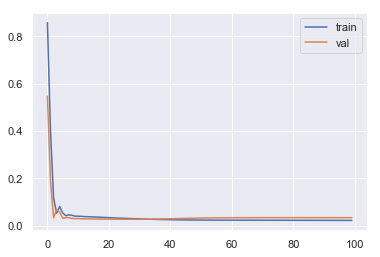

In [950]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
# Simple network of one LSTM layer with 50 nodes and one dense layer for the prediction
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=1000, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

The graph shows that the model is performing equally good on the training and validation sets (The validation set is not seen before and never used to train the algorithm), this means the model will predict the next month total amount of a merchant based on his activities in the previous 6 months, in a similar way as it did in the training.

More investigations and networks architectures and more data is required to enhance the model and reduce the prediction error on the validation set (this number is called val_loss, it can be seen in the result of the cell above, and our goal is to reduce it as much as we can).